In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.data import shepp_logan_phantom
import astra

In [ ]:
def getPhantom(nx, r = 0.9):
    """
    Define phantom image.
    
    input:
        nx - dimension of the input image
        r - radius of phantom, optional (default = 0.9)
    
    output:
        u - phantom image as 1d array of length nx*nx
    """
    # mask
    mask = np.zeros((nx,nx))
    ii,jj = disk((nx//2,nx//2),r * (nx//2))
    mask[ii,jj] = 1
    
    # binary blobs
    u = 0.5 * np.float64(binary_blobs(length=nx, blob_size_fraction=0.5))
    u += 0.5 * np.float64(binary_blobs(length=nx, blob_size_fraction=0.2))
    u *= mask
    
    # return
    return u

In [2]:
# settings
nx = 128
na = 180
nd = int(1.5*nx)
angles = np.linspace(0,np.pi,na,False)

In [3]:
# astra  projector
vol_geom = astra.create_vol_geom(nx,nx)
proj_geom = astra.create_proj_geom('parallel', 1.0, nd, angles)
proj_id = astra.create_projector('strip', proj_geom, vol_geom)

In [ ]:
# generate data
u = getPhantom(nx)
f_id, f = astra.create_sino(u, proj_id)

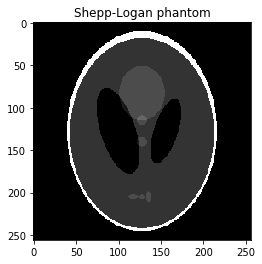

In [4]:
# plot
fig,ax = plt.subplots(1,2)

ax[0].imshow(u)
ax[0].set_title('ground truth')

ax[1].imshow(f)
ax[1].set_title('sinogram')

In [7]:
# Create a data object for the reconstruction
rec_id = astra.data2d.create('-vol', vol_geom)

# Set up the parameters for a reconstruction algorithm using the CPU
# The main difference with the configuration of a GPU algorithm is the
# extra ProjectorId setting.
cfg = astra.astra_dict('SIRT')
cfg['ReconstructionDataId'] = rec_id
cfg['ProjectionDataId'] = sinogram_id
cfg['ProjectorId'] = proj_id

# Available algorithms:
# ART, SART, SIRT, CGLS, FBP

In [8]:
# Create the algorithm object from the configuration structure
alg_id = astra.algorithm.create(cfg)

# Run 20 iterations of the algorithm
# This will have a runtime in the order of 10 seconds.
astra.algorithm.run(alg_id, 20)

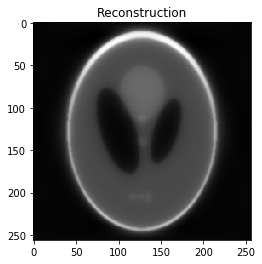

In [9]:
# Get the result
u_rec = astra.data2d.get(rec_id)

In [ ]:
# plot
fig,ax = plt.subplots(1,3)

ax[0].imshow(u)
ax[0].set_title('ground truth')

ax[1].imshow(f)
ax[1].set_title('sinogram')

ax[2].imshow(u_rec)
ax[2].set_title('reconstruction')

In [10]:
# Clean up.
astra.algorithm.delete(alg_id)
astra.data2d.delete(rec_id)
astra.data2d.delete(sinogram_id)
astra.projector.delete(proj_id)